In [1]:
!nvidia-smi

Fri May 31 16:48:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   56C    P0   318W / 400W |  12232MiB / 40960MiB |     99%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   

In [2]:
import torch


# Function to list available GPUs and select one
def select_device():
    if torch.cuda.is_available():
        print("Available GPUs:")
        for i in range(torch.cuda.device_count()):
            print(f"{i}: {torch.cuda.get_device_name(i)}")
        device_id = int(input("Select GPU by entering the device ID (default 0): ") or 0)
        if device_id < torch.cuda.device_count():
            print(f"Using GPU: {torch.cuda.get_device_name(device_id)}")
            return torch.device(f"cuda:{device_id}")
        else:
            print(f"Invalid device ID. Using GPU: {torch.cuda.get_device_name(0)}")
            return torch.device("cuda:0")
    else:
        print("No GPU available. Using CPU.")
        return torch.device("cpu")

# Select the device
device = select_device()

Available GPUs:
0: NVIDIA A100-SXM4-40GB
1: NVIDIA A100-SXM4-40GB
2: NVIDIA A100-SXM4-40GB
3: NVIDIA A100-SXM4-40GB
4: NVIDIA A100-SXM4-40GB
5: NVIDIA A100-SXM4-40GB
6: NVIDIA A100-SXM4-40GB
7: NVIDIA A100-SXM4-40GB
Select GPU by entering the device ID (default 0): 4
Using GPU: NVIDIA A100-SXM4-40GB


In [3]:
import os
import torch
from transformers import RobertaForSequenceClassification, RobertaTokenizer

# Function to load the model
def load_model(snapshot_path, model_name="FacebookAI/roberta-large", num_labels=3):
    model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.load_state_dict(torch.load(snapshot_path, map_location=device))
    model.to(device)
    return model

# Function to list all model snapshot files in a directory that match the naming pattern
def list_snapshot_files(snapshot_directory):
    return [os.path.join(snapshot_directory, file_name) for file_name in os.listdir(snapshot_directory) 
            if file_name.startswith('roberta_large_anli1_cycle_') and file_name.endswith('.pth')]

# Load all models
snapshot_directory = '/storage/data/st1070263'
snapshot_files = list_snapshot_files(snapshot_directory)
model_snapshots = [load_model(snapshot) for snapshot in snapshot_files]

/opt/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

In [4]:
import pandas as pd

# Path to the test data and loading it
test_data_path = 'ANLI/test_r1.csv'
df_anli_test = pd.read_csv(test_data_path)

# Including 'reason' column in the contextual input
df_anli_test['contextual_input'] = df_anli_test['premise'] + " [SEP] " + df_anli_test['hypothesis'] + " [SEP] " + df_anli_test['reason']
df_anli_test.dropna(subset=['contextual_input', 'label'], inplace=True)
df_anli_test['label'] = df_anli_test['label'].astype(int)

In [5]:
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, Dataset
import torch


# Tokenization and Dataset Preparation
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-large")


class ANLITestDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def tokenize_data_with_reason(df, tokenizer):
    return tokenizer(df['contextual_input'].tolist(), padding=True, truncation=True, max_length=512, return_tensors="pt")


# Prepare the test dataset
encodings_with_reason = tokenize_data_with_reason(df_anli_test, tokenizer)
anli_test_dataset_with_reason = ANLITestDataset(encodings_with_reason, df_anli_test['label'].tolist())
anli_test_loader_with_reason = DataLoader(anli_test_dataset_with_reason, batch_size=32, shuffle=False)


In [6]:
from tqdm import tqdm
import torch

# Evaluate model and get predictions with reason
def get_model_predictions_with_reason(model, loader):
    model.eval()
    all_probs = []
    for batch in tqdm(loader, desc="Evaluating", leave=False):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        with torch.no_grad():
            outputs = model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            all_probs.append(probabilities.detach())
    torch.cuda.empty_cache()
    return torch.cat(all_probs, dim=0)

model_probs_with_reason = {}
for i, model in enumerate(model_snapshots):
    print(f"Processing Model {i+1} with reason")
    probabilities_with_reason = get_model_predictions_with_reason(model, anli_test_loader_with_reason)
    model_probs_with_reason[f'model_{i+1}_probs'] = probabilities_with_reason.cpu().numpy()


Processing Model 1 with reason


Evaluating:   0%|                                        | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_609842/788940528.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Processing Model 2 with reason


Processing Model 3 with reason


Processing Model 4 with reason


Processing Model 5 with reason


Processing Model 6 with reason


Processing Model 7 with reason


In [7]:
import pandas as pd


# Load the data for predictions that include the reason column
model_prob_df = pd.DataFrame()
for key, probs in model_probs_with_reason.items():
    df_probs = pd.DataFrame(probs, columns=[f'{key}_class_0', f'{key}_class_1', f'{key}_class_2'])
    model_prob_df = pd.concat([model_prob_df, df_probs], axis=1)

# Save the DataFrame to a CSV file
model_prob_df.to_csv('model_probabilities_with_reason.csv', index=False)
print("Model predictions stored in 'model_probabilities_with_reason.csv'")


Model predictions stored in 'model_probabilities_with_reason.csv'


In [8]:
model_prob_df

,model_1_probs_class_0,model_1_probs_class_1,model_1_probs_class_2,model_2_probs_class_0,model_2_probs_class_1,model_2_probs_class_2,model_3_probs_class_0,model_3_probs_class_1,model_3_probs_class_2,model_4_probs_class_0,...,model_4_probs_class_2,model_5_probs_class_0,model_5_probs_class_1,model_5_probs_class_2,model_6_probs_class_0,model_6_probs_class_1,model_6_probs_class_2,model_7_probs_class_0,model_7_probs_class_1,model_7_probs_class_2
0,0.995955,0.002309,0.001735,0.453937,0.234938,0.311125,0.975081,0.015052,0.009867,0.994125,...,0.003181,0.478546,0.209742,0.311712,0.708032,0.113943,0.178025,0.967613,0.017675,0.014712
1,0.921673,0.003573,0.074754,0.447572,0.240428,0.312000,0.716421,0.074690,0.208889,0.399538,...,0.589406,0.460462,0.222988,0.316550,0.393119,0.038234,0.568647,0.808556,0.010778,0.180666
2,0.981688,0.001364,0.016947,0.444473,0.240985,0.314542,0.962230,0.006846,0.030924,0.982405,...,0.016667,0.425426,0.201559,0.373015,0.800167,0.022035,0.177798,0.898381,0.011686,0.089934
3,0.879213,0.035879,0.084908,0.444795,0.239167,0.316038,0.769570,0.131701,0.098730,0.847227,...,0.029856,0.419022,0.239622,0.341356,0.443442,0.322854,0.233704,0.609160,0.303432,0.087409
4,0.023634,0.003885,0.972481,0.440584,0.238663,0.320753,0.121195,0.029225,0.849580,0.003300,...,0.995001,0.406080,0.209482,0.384438,0.137451,0.041743,0.820806,0.032372,0.009191,0.958437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.005234,0.002231,0.992535,0.440914,0.239054,0.320032,0.298985,0.023508,0.677507,0.074218,...,0.913583,0.392680,0.198039,0.409281,0.058636,0.041714,0.899649,0.044990,0.031401,0.923609
996,0.029680,0.965641,0.004679,0.441487,0.240795,0.317718,0.066286,0.904615,0.029099,0.005243,...,0.001050,0.442189,0.288863,0.268948,0.096896,0.783850,0.119254,0.042962,0.942460,0.014578
997,0.994565,0.001283,0.004151,0.444698,0.245506,0.309795,0.977880,0.011210,0.010910,0.994544,...,0.004345,0.452720,0.276622,0.270658,0.918582,0.033409,0.048009,0.978822,0.008691,0.012487
998,0.989728,0.007850,0.002422,0.446451,0.241364,0.312185,0.963514,0.024877,0.011609,0.994335,...,0.001671,0.443536,0.244333,0.312131,0.497367,0.347122,0.155510,0.965385,0.020418,0.014197


In [9]:
# Add the true labels to the model probabilities DataFrame
model_prob_df['True_labels'] = df_anli_test['label'].values

In [10]:
model_prob_df

,model_1_probs_class_0,model_1_probs_class_1,model_1_probs_class_2,model_2_probs_class_0,model_2_probs_class_1,model_2_probs_class_2,model_3_probs_class_0,model_3_probs_class_1,model_3_probs_class_2,model_4_probs_class_0,...,model_5_probs_class_0,model_5_probs_class_1,model_5_probs_class_2,model_6_probs_class_0,model_6_probs_class_1,model_6_probs_class_2,model_7_probs_class_0,model_7_probs_class_1,model_7_probs_class_2,True_labels
0,0.995955,0.002309,0.001735,0.453937,0.234938,0.311125,0.975081,0.015052,0.009867,0.994125,...,0.478546,0.209742,0.311712,0.708032,0.113943,0.178025,0.967613,0.017675,0.014712,0
1,0.921673,0.003573,0.074754,0.447572,0.240428,0.312000,0.716421,0.074690,0.208889,0.399538,...,0.460462,0.222988,0.316550,0.393119,0.038234,0.568647,0.808556,0.010778,0.180666,0
2,0.981688,0.001364,0.016947,0.444473,0.240985,0.314542,0.962230,0.006846,0.030924,0.982405,...,0.425426,0.201559,0.373015,0.800167,0.022035,0.177798,0.898381,0.011686,0.089934,0
3,0.879213,0.035879,0.084908,0.444795,0.239167,0.316038,0.769570,0.131701,0.098730,0.847227,...,0.419022,0.239622,0.341356,0.443442,0.322854,0.233704,0.609160,0.303432,0.087409,1
4,0.023634,0.003885,0.972481,0.440584,0.238663,0.320753,0.121195,0.029225,0.849580,0.003300,...,0.406080,0.209482,0.384438,0.137451,0.041743,0.820806,0.032372,0.009191,0.958437,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.005234,0.002231,0.992535,0.440914,0.239054,0.320032,0.298985,0.023508,0.677507,0.074218,...,0.392680,0.198039,0.409281,0.058636,0.041714,0.899649,0.044990,0.031401,0.923609,0
996,0.029680,0.965641,0.004679,0.441487,0.240795,0.317718,0.066286,0.904615,0.029099,0.005243,...,0.442189,0.288863,0.268948,0.096896,0.783850,0.119254,0.042962,0.942460,0.014578,1
997,0.994565,0.001283,0.004151,0.444698,0.245506,0.309795,0.977880,0.011210,0.010910,0.994544,...,0.452720,0.276622,0.270658,0.918582,0.033409,0.048009,0.978822,0.008691,0.012487,0
998,0.989728,0.007850,0.002422,0.446451,0.241364,0.312185,0.963514,0.024877,0.011609,0.994335,...,0.443536,0.244333,0.312131,0.497367,0.347122,0.155510,0.965385,0.020418,0.014197,1


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Step 1: Calculate Individual Model Accuracy
def calculate_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

n_models = len(model_snapshots)  # Adjust the number of models based on your ensemble
accuracy_per_model = {}
for i in range(1, n_models + 1):
    probs = model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    accuracy_per_model[f'model_{i}'] = calculate_accuracy(probs, model_prob_df['True_labels'].values)

# Step 2: Calculate Correlations Between Model Predictions
correlation_matrix = np.zeros((n_models, n_models))
for i in range(1, n_models + 1):
    for j in range(1, n_models + 1):
        true_class_probs_i = model_prob_df[[f'model_{i}_probs_class_{k}' for k in model_prob_df['True_labels']]].values
        true_class_probs_j = model_prob_df[[f'model_{j}_probs_class_{k}' for k in model_prob_df['True_labels']]].values
        correlation_matrix[i-1, j-1] = np.corrcoef(true_class_probs_i.ravel(), true_class_probs_j.ravel())[0, 1]

# Display results
print("Accuracy per model:", accuracy_per_model)
print("Correlation matrix between model predictions:\n", correlation_matrix)

Accuracy per model: {'model_1': 0.777, 'model_2': 0.334, 'model_3': 0.779, 'model_4': 0.778, 'model_5': 0.349, 'model_6': 0.777, 'model_7': 0.802}
Correlation matrix between model predictions:
 [[ 1.00000000e+00  1.84177276e-01  9.27903807e-01  8.74202161e-01
   2.67127875e-01  8.46463283e-01  9.19075203e-01]
 [ 1.84177276e-01  1.00000000e+00  1.87143927e-01 -6.96046003e-04
   8.87902297e-01  4.21013921e-02  8.83961511e-02]
 [ 9.27903807e-01  1.87143927e-01  1.00000000e+00  8.66484268e-01
   2.80358618e-01  8.80810020e-01  9.34758154e-01]
 [ 8.74202161e-01 -6.96046003e-04  8.66484268e-01  1.00000000e+00
   1.15659596e-01  8.51816087e-01  9.05410223e-01]
 [ 2.67127875e-01  8.87902297e-01  2.80358618e-01  1.15659596e-01
   1.00000000e+00  1.52898658e-01  1.99944269e-01]
 [ 8.46463283e-01  4.21013921e-02  8.80810020e-01  8.51816087e-01
   1.52898658e-01  1.00000000e+00  9.10073932e-01]
 [ 9.19075203e-01  8.83961511e-02  9.34758154e-01  9.05410223e-01
   1.99944269e-01  9.10073932e-01  1.0

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, title):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=.5)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Accuracy of the averaged model: 0.807
Categorical Cross-Entropy Loss of the averaged model: 0.5934909352362155


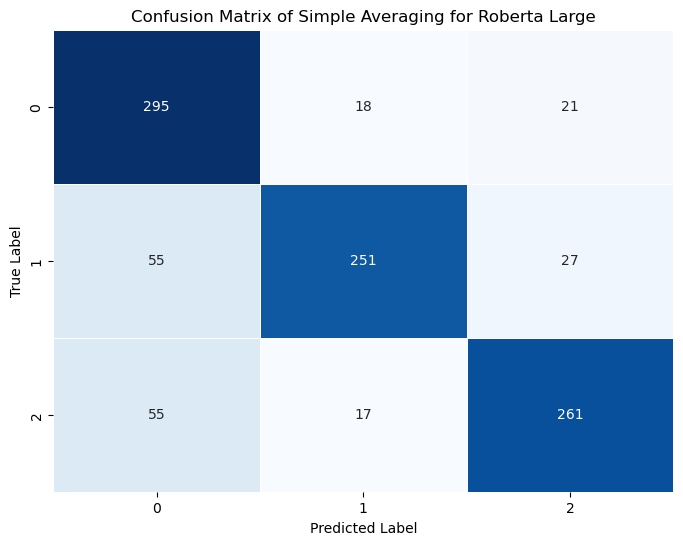

In [13]:
# Compute the average probabilities across all models
average_probs = np.mean([
    model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    for i in range(1, n_models + 1)
], axis=0)

# Determine predicted labels from the average probabilities
predicted_labels_from_average = np.argmax(average_probs, axis=1)

# Calculate accuracy of the averaged model
average_model_accuracy = np.mean(predicted_labels_from_average == model_prob_df['True_labels'].values)

print("Accuracy of the averaged model:", average_model_accuracy)

import numpy as np

def one_hot_encode(labels, num_classes):
    """ Convert array of labels to one-hot encoded numpy array. """
    return np.eye(num_classes)[labels]

def categorical_cross_entropy(true_labels, predicted_probs):
    """ Compute the categorical cross-entropy loss. """
    true_labels_one_hot = one_hot_encode(true_labels, num_classes=predicted_probs.shape[1])
    log_probs = np.log(predicted_probs + 1e-15)  # Adding a small epsilon to avoid log(0)
    loss = -np.sum(true_labels_one_hot * log_probs) / true_labels_one_hot.shape[0]
    return loss

# Assuming 'average_probs' is already calculated as suggested in the previous step
true_labels = model_prob_df['True_labels'].values
loss = categorical_cross_entropy(true_labels, average_probs)

print("Categorical Cross-Entropy Loss of the averaged model:", loss)

# Plotting the confusion matrix for the Simple Averaging method
plot_confusion_matrix(true_labels, predicted_labels_from_average, 'Confusion Matrix of Simple Averaging for Roberta Large')


Accuracy of the majority vote: 0.737
Adjusted Categorical Cross-Entropy Loss for the majority vote: 1.1017980634493731


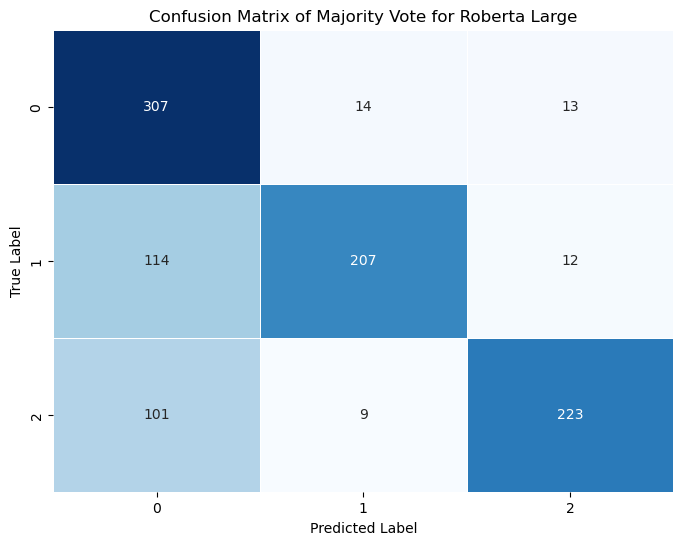

In [14]:
import numpy as np

# Assuming you have a DataFrame called 'model_prob_df' which includes the predicted probabilities for each class
# from each model and it looks something like this:
# Columns: ['model_1_probs_class_0', 'model_1_probs_class_1', 'model_1_probs_class_2', ..., 'model_5_probs_class_0', 'model_5_probs_class_1', 'model_5_probs_class_2', 'True_labels']

# Extract predicted labels for each model
predicted_labels = {}
n_models = 5  # Adjust the number of models based on your ensemble
for i in range(1, n_models + 1):
    probs = model_prob_df[[f'model_{i}_probs_class_0', f'model_{i}_probs_class_1', f'model_{i}_probs_class_2']].values
    predicted_labels[f'model_{i}'] = np.argmax(probs, axis=1)

# Constructing an array of all predictions
all_predictions = np.vstack([predicted_labels[f'model_{i}'] for i in range(1, n_models + 1)])

# Majority vote calculation
majority_vote = np.apply_along_axis(lambda x: np.bincount(x, minlength=3).argmax(), 0, all_predictions)

# Calculate the accuracy of the majority vote
true_labels = model_prob_df['True_labels'].values
majority_vote_accuracy = np.mean(majority_vote == true_labels)

print("Accuracy of the majority vote:", majority_vote_accuracy)
# Assuming majority_vote contains the predicted labels from your majority vote procedure
num_classes = 3  # Set this to the number of classes in your dataset
majority_vote_probs = one_hot_encode(majority_vote, num_classes)

def smooth_one_hot(true_labels, num_classes, smoothing=0.1):
    """
    Apply label smoothing. Default epsilon is 0.1.
    This helps to mitigate the issue with hard zero probabilities leading to infinite loss.
    """
    # Create an array where all elements are equal to a small value (smoothing / num_classes)
    confidence = 1.0 - smoothing
    smooth_prob = smoothing / num_classes
    one_hot_labels = np.eye(num_classes)[true_labels]
    return one_hot_labels * confidence + smooth_prob

# Calculate the smoothed probabilities for the majority vote predictions
majority_vote_smooth_probs = smooth_one_hot(majority_vote, num_classes, smoothing=0.05)  # Smoothing with a small epsilon value

# Calculate loss with the smoothed probabilities
loss = categorical_cross_entropy(true_labels, majority_vote_smooth_probs)

print("Adjusted Categorical Cross-Entropy Loss for the majority vote:", loss)


# Plotting the confusion matrix for the Majority Vote method
plot_confusion_matrix(true_labels, majority_vote, 'Confusion Matrix of Majority Vote for Roberta Large')
